In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
from scipy.stats import ttest_ind

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from sqlalchemy.sql.expression import extract

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

base = automap_base()

# reflect the tables

base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found

base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table

measurement = base.classes.measurement 
station = base.classes.station


In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
#inspecting the data

inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns("measurement")

for column in columns: 
    primarykeystr = ""
    if column ["primary_key"] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [11]:
columns = inspector.get_columns("station")

for column in columns: 
    primarykeystr = ""
    if column["primary_key"] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


In [12]:
#getting the total number of dates recorded 

session.query(func.count(measurement.date)).all()

[(19550,)]

In [13]:
#getting the earliest and latest date recorded 

earliest = session.query(measurement.date).order_by(measurement.date).first()
latest = session.query(measurement.date).order_by(measurement.date.desc()).first()

print(f"Earliest Date: {earliest} , Latest Date: {latest}")

Earliest Date: ('2010-01-01',) , Latest Date: ('2017-08-23',)


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

latestdate = dt.datetime.strptime(latest[0], '%Y-%m-%d') 
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
# querydate

select = [measurement.date, measurement.prcp]

queryresult = session.query(*select).filter(measurement.date >= querydate).all()
# queryresult



In [15]:
#making data frame to plot 

prcp = pd.DataFrame(queryresult, columns = ["Date", "Precipitation"])
prcp = prcp.dropna()
prcp = prcp.sort_values(["Date"], ascending=True)
prcp.set_index("Date")
prcp.head()

,Date,Precipitation
0,2016-08-23,0.00
1192,2016-08-23,0.02
704,2016-08-23,0.05
1881,2016-08-23,0.70
361,2016-08-23,0.15


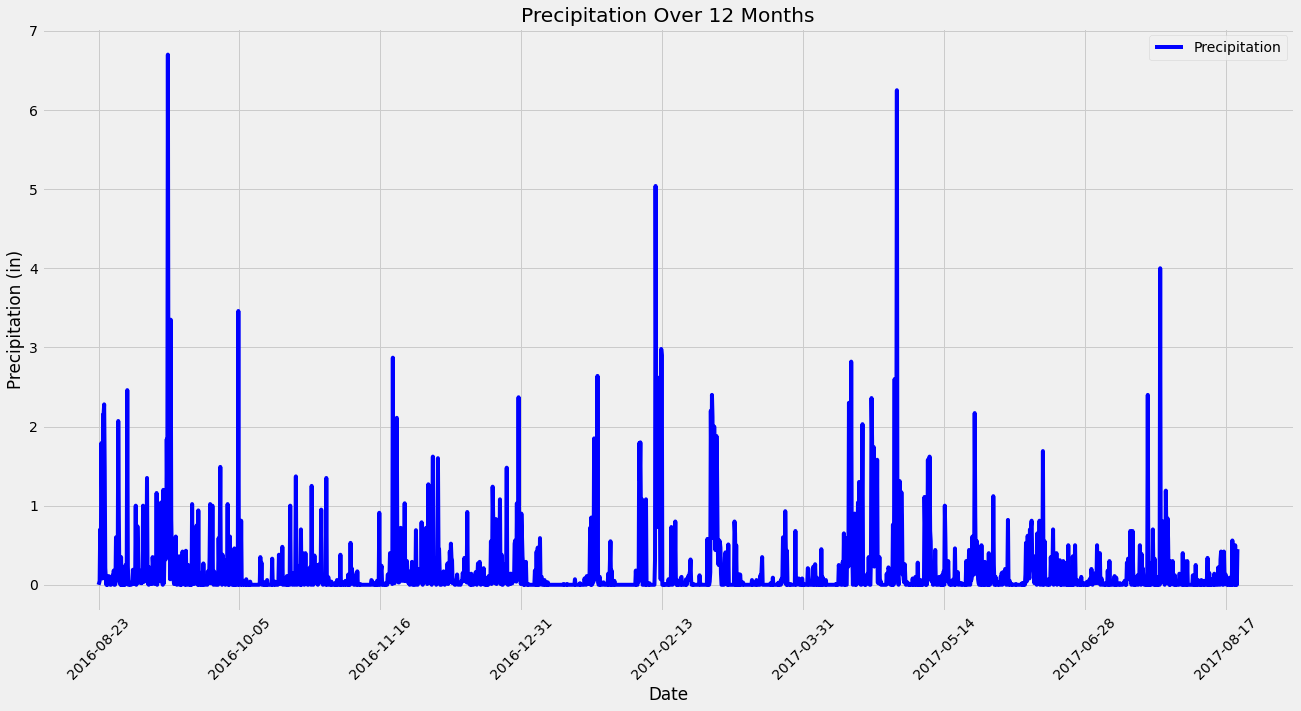

In [16]:
#plotting 

prcp.plot("Date", "Precipitation", rot=45, color="blue" ,figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Precipitation Over 12 Months")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset

session.query(station.id).count()


9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

select = [measurement.station,func.count(measurement.id)]

activestations = session.query(*select).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
    
activestations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

select = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]

mostactive = session.query(*select). \
    group_by(measurement.station). \
    order_by(func.count(measurement.id).desc()).first()

mostactive

(54.0, 85.0, 71.66378066378067)

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

queryresult = session.query(measurement.tobs). \
    filter(measurement.station == activestations[0][0]) .\
    filter (measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

select = [station.station, station.name, station.latitude, station.longitude, station.elevation]

queryresult = session.query(*select).all()

#data frame for plotting 

stations_df = pd.DataFrame(queryresult, columns = ["Station", "Name", "Latitude", "Longitude", "Elevation"])
# stations_df.head()

#defining the station needed 

stationname = stations_df.loc[stations_df["Station"]==activestations[0][0], "Name"].tolist()[0]


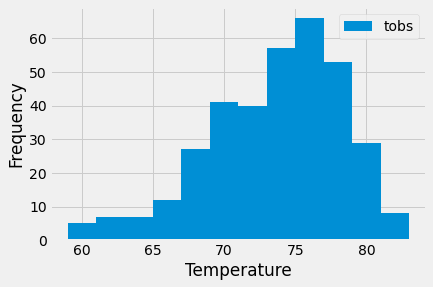

In [22]:
# plotting histogram 

plt.hist(temperatures, bins=12, rwidth=1.0, label="tobs")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend()
plt.show()

# Bonus: Temperature Analysis I


In [23]:
# get june temperatures for all years 

june_temp = session.query(measurement.date, measurement.tobs) \
    .filter(extract("month", measurement.date)=="6").all()
# june_temp

In [24]:
#putting june temps in a dataframe 

june_temp = pd.DataFrame(june_temp)
june_temp = june_temp.rename(columns={0: "Date"})
june_temp = june_temp.rename(columns={1: "Temperature"})
june_temp.head()

,Date,Temperature
0,2010-06-01,78.0
1,2010-06-02,76.0
2,2010-06-03,78.0
3,2010-06-04,76.0
4,2010-06-05,77.0


In [25]:
#getting june average temp

june_avg = june_temp["Temperature"].mean()
june_avg

74.94411764705882

In [26]:
# getting december temperatures 

dec_temps = session.query(measurement.date, measurement.tobs) \
    .filter(extract("month", measurement.date)== "12").all()
# dec_temps

In [27]:
#putting dec temps into data frame 

dec_temps = pd.DataFrame(dec_temps)
dec_temps = dec_temps.rename(columns={0:"Date"})
dec_temps = dec_temps.rename(columns={1:"Temperature"})
dec_temps.head()

,Date,Temperature
0,2010-12-01,76.0
1,2010-12-03,74.0
2,2010-12-04,74.0
3,2010-12-06,64.0
4,2010-12-07,64.0


In [28]:
#getting december average temp

dec_avg = dec_temps["Temperature"].mean()
dec_avg

71.04152933421226

In [29]:
#running the paired t-test

june = june_temp["Temperature"]
dec = dec_temps["Temperature"]

result = ttest_ind(june,dec)
# result

### Analysis

The t-test was used to calculate two independent samples: June Temperatures vs December Temperature across all years in the dataset. 

The results" t = 31.60, p = 3.90

Conclusion - there is not sufficient evidence to conclude that there is a significant difference in averages across all years available. 



## Bonus Challenge Assignment: Temperature Analysis II

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [31]:
# temperature data for dates provided 

startdate = "2017-06-01"
enddate = "2017-06-07"

tempresult = calc_temps(startdate, enddate)[0]
tempresult

(74.0, 77.84444444444445, 81.0)

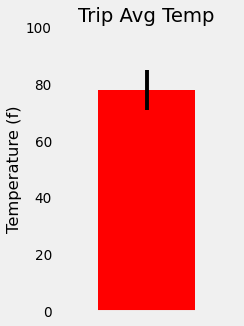

In [32]:
#Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_position = [0]
y_position = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]
w = 3
h = 5 
d = 70

#plotting 

plt.figure(figsize=(w,h), dpi=d)
plt.bar(x_position, y_position, color = "red", yerr=error)
plt.xlim(-0.75, 0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (f)")
plt.ylim(0,100)
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.grid(which="major", axis = "x", linestyle='')
plt.grid(which = "major", axis="y", linestyle = "-")
plt.show()

### Daily Rainfall Average

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate = "2017-06-01"
enddate = "2017-06-07"

sel = [station.station,station.name,station.latitude,station.longitude,station.elevation,func.sum(measurement.prcp)]
queryresult = session.query(*sel).\
    filter(station.station == measurement.station).\
    group_by(measurement.station).\
    filter(measurement.date >= startdate).\
    filter(measurement.date <= enddate).\
    order_by(func.sum(measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations


,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.85
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.48
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.38
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.35
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.15
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [34]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

startdate = "2017-06-01"
enddate = "2017-06-07"

In [36]:
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

dateobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddateobj= dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normals = []

while (dateobj <= enddateobj):
    tripdates.append(dt.datetime.strftime(dateobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dateobj, '%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dateobj = dateobj + dt.timedelta(days = 1)

# normals

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

temp_history = pd.DataFrame(normals, columns = ["T-Min", "T-Avg", "T-Max"])
temp_history["Date"] = tripdates
temp_history = temp_history.set_index("Date")
temp_history

,T-Min,T-Avg,T-Max
Date,,,
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0


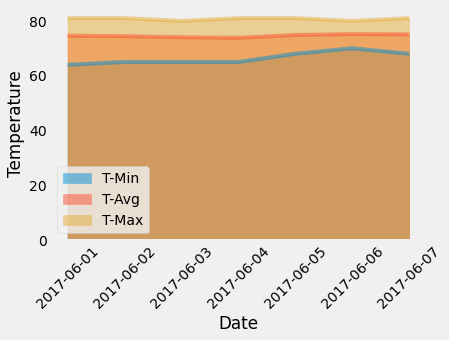

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
temp_history.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel ("Temperature")
plt.grid()
plt.show()

# Close session

In [39]:
# Close Session
session.close()